## Extended MFRM evaluation study code

This Jupyter notebook contains the code needed to run the simulations included in Elliott & Buttery (2022) using `RaschPy` to produce CPAT estimatesunder different MFRM models for comparison. The code produces simulated response data with a set of (by default) 4 anchor raters with no effects and 8 non-anchor raters with a mixture of halo effect and central tendency. Each rater rats a set of `batch_size` (user-definable) individually, and a further set of `batch_size` responses are rated by all raters. The code then produces estimates under global, vector-by-item, vector-by-threshold and matrix MFRMs and produces graphical and statistical comparisons. Experiment parameters are user-definable; full details may be found in Elliott & Buttery (2022).

**References**

&nbsp;&nbsp;&nbsp;&nbsp; Elliott, M., & Buttery, P. J. (2022a) Non-iterative Conditional Pairwise Estimation for the Rating Scale Model, *Educational and Psychological Measurement*, *82*(5), 989-1019.

&nbsp;&nbsp;&nbsp;&nbsp; Elliott, M. and Buttery, P. J. (2022b) Extended Rater Representations in the Many-Facet Rasch Model, *Journal of Applied Measurement*, *22*(1), 133-160.

&nbsp;&nbsp;&nbsp;&nbsp; Linacre, J. M. (1994). *Many-Facet Rasch Measurement*. MESA Press.

&nbsp;&nbsp;&nbsp;&nbsp; Luecht, R., & Ackerman, T. A. (2018). A technical note on IRT simulation studies: dealing with truth, estimates, observed data, and residuals. *Educational Measurement: Issues and Practice*, *37*(3), 65–76.

&nbsp;&nbsp;&nbsp;&nbsp; Warm, T. A. (1989). Weighted likelihood estimation of ability in item response theory. *Psychometrika*, *54*(3), 427–450.


Import packages and set working directory (change this as appropriate).

In [66]:
import RaschPy as rp
import numpy as np
import pandas as pd
import random
import os
import pickle
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rc
import seaborn as sns

os.chdir('my_working_directory')

Set the high-level parameters for the experiment. These may be adjusted to create different conditions to test.

In [67]:
no_of_items = 8
max_score = 5
no_of_raters = 12
no_of_anchors = 4
batch_size = 50
sample_size = (no_of_raters + 1) * batch_size
add_smoo = 0.1

Generate item difficulties, thresholds and person abilities. These, together with the rater severities (below) may be adjusted to test different scenarios such as different kinds of rater effects, or the relative effect of the same rater effect on differnt item/threshold structures.

In [68]:
fixed_diffs = np.array([-0.5, -0.5, 0.5, 0.5, -0.5, -0.5, 0.5, 0.5])
fixed_thresholds = np.array([0, -2, -1, 0, 1, 2])

fixed_abilities = np.random.normal(0, 1.5, sample_size)

fixed_ability_series = pd.Series({f'Person {i + 1}': abil
                                 for i, abil in enumerate(fixed_abilities)})
fixed_ability_series.to_csv(f'person_abilities_{batch_size}.csv', header=False)

Generate rater severities

In [69]:
sevs_items = [0, 0, -1, -1, 0, 0, -1, -1]
sevs_items = np.array(sevs_items).astype(np.float64)

sevs_thresholds = [0, -2, -1, 0, 1, 2]
sevs_thresholds = np.array(sevs_thresholds).astype(np.float64)

sevs_anchors = {f'Rater_{rater + 1}':
                {f'Item_{item + 1}':
                 np.array([0 for thresh in range(max_score + 1)])
                 for item in range(no_of_items)}
                for rater in range(no_of_anchors)}

sevs_non_anchors = {f'Rater_{rater + no_of_anchors + 1}':
                    {f'Item_{item + 1}':
                     np.array([item_sev + thresh_sev
                               if thresh > 0 else 0
                               for thresh, thresh_sev in enumerate(sevs_thresholds)])
                     for item, item_sev in enumerate(sevs_items)}
                    for rater in range(no_of_raters - no_of_anchors)}

severities = {**sevs_anchors, **sevs_non_anchors}

Generate simulation

In [70]:
sim = rp.MFRM_Sim_Matrix(no_of_items=no_of_items, no_of_persons=sample_size, no_of_raters=no_of_raters, 
                         max_score=max_score, max_disorder=0, offset=0, missing=0,
                         manual_abilities=fixed_abilities,
                         manual_diffs=fixed_diffs,
                         manual_thresholds=fixed_thresholds,
                         manual_severities=severities)

Remove responses from simulation (where all raters rate all persons) to create data design with one set of scripts (n = `batch_size`) rated by all raters and a further n scripts rated by one rater for each rater.

In [71]:
for rater in range(no_of_raters):
    for i, person in enumerate(sim.persons):
        if (i not in range(batch_size)) & (i not in range((rater + 1) * batch_size,
                                                          (rater + 2) * batch_size)):
            sim.scores.loc[(f'Rater_{rater + 1}', person), :] = np.nan

Create MFRM object and calibrate 

In [72]:
mfrm = rp.MFRM(sim.scores)

mfrm.calibrate_global(constant=add_smoo)
mfrm.calibrate_items(constant=add_smoo)
mfrm.calibrate_thresholds(constant=add_smoo)
mfrm.calibrate_matrix(constant=add_smoo)

In [73]:
mfrm.calibrate_global_anchor(anchor_raters=['Rater_1', 'Rater_2', 'Rater_3', 'Rater_4'])
mfrm.calibrate_items_anchor(anchor_raters=['Rater_1', 'Rater_2', 'Rater_3', 'Rater_4'])
mfrm.calibrate_thresholds_anchor(anchor_raters=['Rater_1', 'Rater_2', 'Rater_3', 'Rater_4'])
mfrm.calibrate_matrix_anchor(anchor_raters=['Rater_1', 'Rater_2', 'Rater_3', 'Rater_4'])

Create a `pandas` series, `base_abils`, which only contains estimates for persons rated by a single rater (we are not interested in the fully crossed set of scripts for or results). Then generate anchored estimates under each model and similarly remove the fully crossed persons.

In [74]:
base_abils = sim.abilities.copy()[batch_size:]

mfrm.person_abils_global(anchor=True)
mfrm.person_abils_items(anchor=True)
mfrm.person_abils_thresholds(anchor=True)
mfrm.person_abils_matrix(anchor=True)

estimates_global = mfrm.anchor_abils_global.loc[base_abils.index]
estimates_items = mfrm.anchor_abils_items.loc[base_abils.index]
estimates_thresholds = mfrm.anchor_abils_thresholds.loc[base_abils.index]
estimates_matrix = mfrm.anchor_abils_matrix.loc[base_abils.index]

Generate expected score dataframes under the generating parameters and from the estimates for all four models, aexcluding the fully crossed persons.

In [75]:
exp_score_df_generating = {rater: 
                           pd.DataFrame({person: {item:
                                                  mfrm.exp_score_matrix(ability, item, sim.diffs, rater, sim.severities, sim.thresholds)
                                                  for item in sim.items}
                                         for person, ability in sim.abilities.loc[base_abils.index].items()}).T
                           for rater in sim.raters}

exp_score_df_generating = pd.concat(exp_score_df_generating.values(), keys=exp_score_df_generating.keys())

exp_score_df_global = {rater: 
                       pd.DataFrame({person: {item:
                                              mfrm.exp_score_global(ability, item, mfrm.anchor_diffs_global, rater,
                                                                    mfrm.anchor_severities_global, mfrm.anchor_thresholds_global)
                                              for item in sim.items}
                                     for person, ability in sim.abilities.loc[base_abils.index].items()}).T
                       for rater in sim.raters}

exp_score_df_global = pd.concat(exp_score_df_global.values(), keys=exp_score_df_global.keys())

exp_score_df_items = {rater: 
                      pd.DataFrame({person: {item:
                                             mfrm.exp_score_items(ability, item, mfrm.anchor_diffs_items, rater,
                                                                  mfrm.anchor_severities_items, mfrm.anchor_thresholds_items)
                                             for item in sim.items}
                                    for person, ability in sim.abilities.loc[base_abils.index].items()}).T
                      for rater in sim.raters}

exp_score_df_items = pd.concat(exp_score_df_items.values(), keys=exp_score_df_items.keys())

exp_score_df_thresholds = {rater: 
                           pd.DataFrame({person: {item:
                                                  mfrm.exp_score_thresholds(ability, item, mfrm.anchor_diffs_thresholds,
                                                                            rater, mfrm.anchor_severities_thresholds,
                                                                            mfrm.anchor_thresholds_thresholds)
                                                  for item in sim.items}
                                         for person, ability in sim.abilities.loc[base_abils.index].items()}).T
                           for rater in sim.raters}

exp_score_df_thresholds = pd.concat(exp_score_df_thresholds.values(), keys=exp_score_df_thresholds.keys())

exp_score_df_matrix = {rater: 
                       pd.DataFrame({person: {item:
                                              mfrm.exp_score_matrix(ability, item, mfrm.anchor_diffs_matrix, rater,
                                                                    mfrm.anchor_severities_matrix, mfrm.anchor_thresholds_matrix)
                                              for item in sim.items}
                                     for person, ability in sim.abilities.loc[base_abils.index].items()}).T
                       for rater in sim.raters}

exp_score_df_matrix = pd.concat(exp_score_df_matrix.values(), keys=exp_score_df_matrix.keys())

Define function to calculate ability estimate from responses under the matrix MFRM, passing whatever set of item/threshold/rater parameters are relevant, plus corresponding function for Warm (1989) bias correction. This function is used to create the pseudo-estimates: ability estimates derived from the generating item, threshold and rater parameters and the response dataframe. Pseudo-estimates effectively remove the stochastic element from comparisons, in the spirit of parameter-estimation residuals (Luecht & Ackerman, 2018). See Elliott & Buttery (2022b) for a full discussion of pseudo-estimates.

**NOTE** 22/1/2025: This function still needs to be added to the `RaschPy` codebase as a proper method.

In [76]:
def abil_matrix(scores,
                person,
                rater,
                diffs,
                thresholds,
                severities,
                warm_corr=False,
                tolerance=0.0000001,
                max_iter=100,
                ext_score_adjustment=0.3):
    
    ext_score = sim.max_score * sim.no_of_items
    
    score = scores.xs(rater).sum(axis=1)[person]
    
    if score == 0:
        used_score = ext_score_adjustment

    elif score == ext_score:
        used_score = score - ext_score_adjustment

    else:
        used_score = score

    estimate = log(used_score) - log(ext_score - used_score)
    
    change = 1
    iterations = 0
    
    while (abs(change) > tolerance) & (iterations <= max_iter):
        
        result = sum(mfrm.exp_score_matrix(estimate,
                                           item,
                                           diffs,
                                           rater,
                                           severities,
                                           thresholds)
                     for item in mfrm.items)
                
        info = sum(mfrm.variance_matrix(estimate,
                                        item,
                                        diffs,
                                        rater,
                                        severities,
                                        thresholds)
                   for item in mfrm.items)

        change = max(-1, min(1, (result - used_score) / info))
        estimate -= change
        iterations += 1

    if warm_corr:
        estimate += warm_matrix(estimate,
                                diffs,
                                rater,
                                severities,
                                thresholds)
    
    return estimate

In [77]:
def warm_matrix(estimate,
                diffs,
                rater,
                severities,
                thresholds):

    '''
    Warm's (1989) bias correction for ML abiity estimates
    '''

    exp_scores = [mfrm.exp_score_matrix(estimate,
                                        item,
                                        diffs,
                                        rater,
                                        severities,
                                        thresholds)
                  for item in mfrm.items]

    variances = [mfrm.variance_matrix(estimate,
                                      item,
                                      diffs,
                                      rater,
                                      severities,
                                      thresholds)
                 for item in mfrm.items]
        
    part_1 = sum(sum((cat ** 3) * mfrm.cat_prob_matrix(estimate,
                                                       item,
                                                       diffs,
                                                       rater,
                                                       severities,
                                                       cat,
                                                       thresholds)
                     for cat in range(mfrm.max_score + 1))
                 for item in mfrm.items)

    part_2 = 3 * sum((variances[i] + (exp_scores[i] ** 2)) *
                     exp_scores[i]
                     for i, item in enumerate(mfrm.items))

    part_3 = sum(2 * (exp_scores[i] ** 3)
                 for i, item in enumerate(mfrm.items))

    warm_correction = ((part_1 - part_2 + part_3) /
                       (2 * (sum(variances[i]
                              for i, item in enumerate(mfrm.items)) ** 2)))

    return warm_correction

Generate pseudo-estimates (not including persons rated by all raters)

In [78]:
from math import trunc
from math import log

pseudo_estimates = {}

for i, person in enumerate(base_abils.index):
    rater_no = trunc(i / batch_size) + 1
    rater = f'Rater_{rater_no}'
    
    pseudo_estimates[person] = abil_matrix(sim.scores, person, rater, sim.diffs, sim.thresholds,
                                           sim.severities, warm_corr=True)
    pseudo_estimates = pd.Series(pseudo_estimates)

Plot pseudo-estimates against the four sets of estimates under the different models (global, vector by item, vector by threshold, matrix) and save to file.

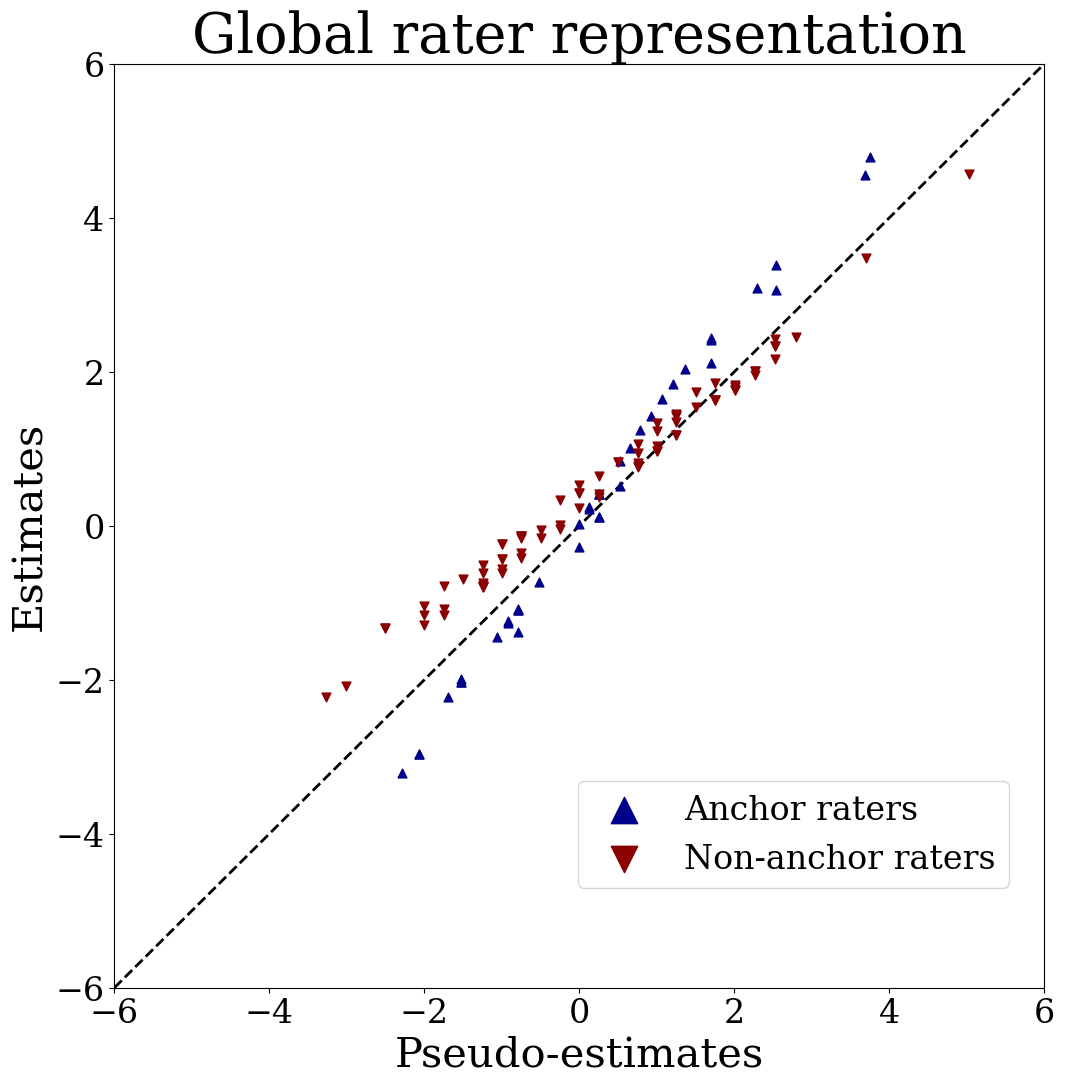

In [79]:
fig, ax = plt.subplots(figsize=(12, 12))

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

plt.plot([-6, 6], [-6, 6], color='k', linestyle='--', linewidth=2, zorder=0)
ax.scatter(pseudo_estimates[:batch_size * no_of_anchors],
           estimates_global[:batch_size * no_of_anchors],
           label="Anchor raters",
           marker='^',
           color='darkblue', s=40)
ax.scatter(pseudo_estimates[batch_size * no_of_anchors:],
           estimates_global[batch_size * no_of_anchors:],
           label="Non-anchor raters",
           marker='v',
           color='darkred', s=40)

plt.xlim(-6, 6)
plt.ylim(-6, 6)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.title('Global rater representation', {'fontsize': 40})
plt.xlabel('Pseudo-estimates', {'fontsize': 30})
plt.ylabel('Estimates', {'fontsize': 30})

ax.legend(loc='lower right', fontsize=24, markerscale=3, bbox_to_anchor=(0.98, 0.09))

plt.savefig(f'scatter_abils_residual_matrix_{batch_size}.png',
            dpi = 200,
            bbox_inches = 'tight',
            pad_inches = 0.1)

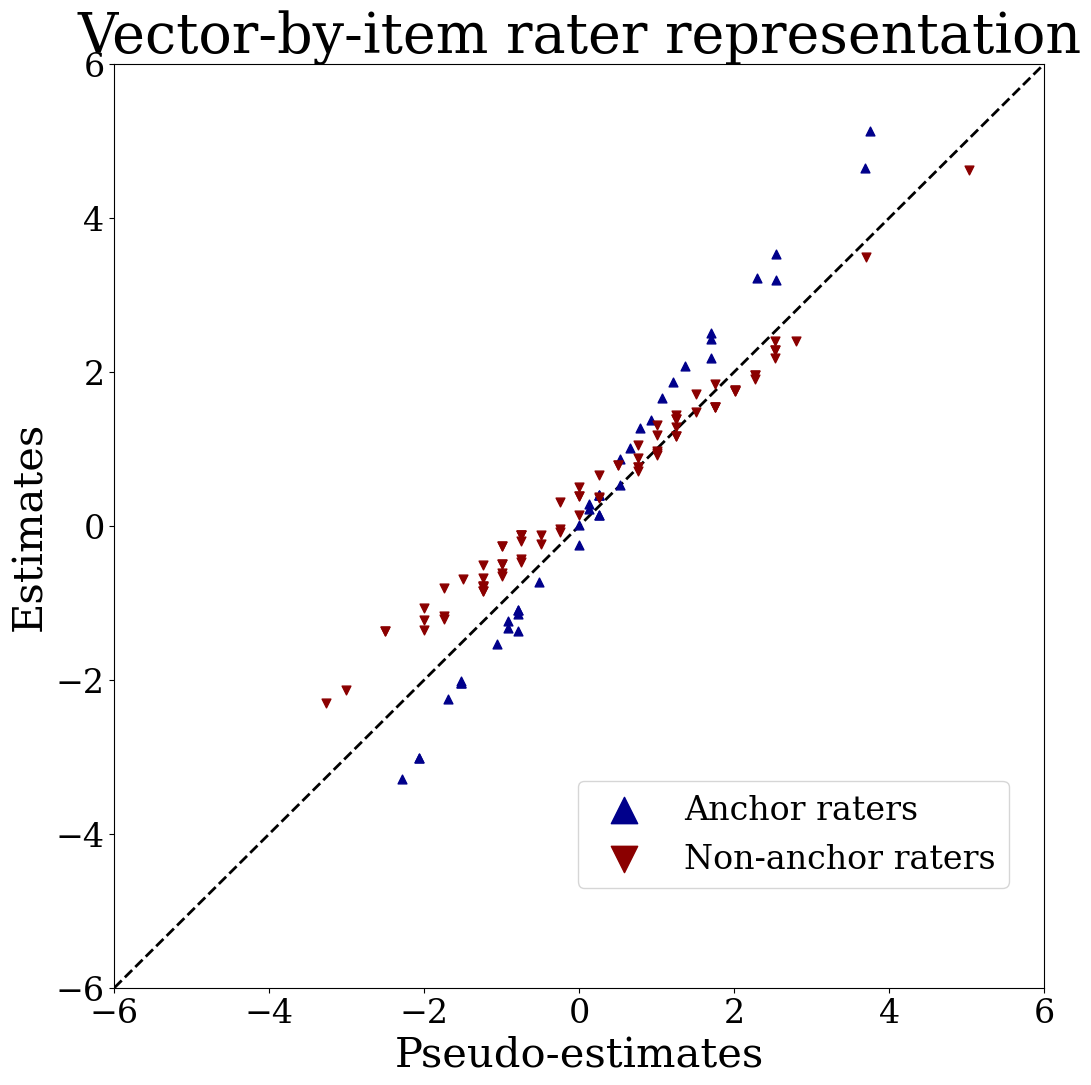

In [80]:
fig, ax = plt.subplots(figsize=(12, 12))

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

plt.plot([-6, 6], [-6, 6], color='k', linestyle='--', linewidth=2, zorder=0)
ax.scatter(pseudo_estimates[:batch_size * no_of_anchors],
           estimates_items[:batch_size * no_of_anchors],
           label="Anchor raters",
           marker='^',
           color='darkblue', s=40)
ax.scatter(pseudo_estimates[batch_size * no_of_anchors:],
           estimates_items[batch_size * no_of_anchors:],
           label="Non-anchor raters",
           marker='v',
           color='darkred', s=40)

plt.xlim(-6, 6)
plt.ylim(-6, 6)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.title('Vector-by-item rater representation', {'fontsize': 40})
plt.xlabel('Pseudo-estimates', {'fontsize': 30})
plt.ylabel('Estimates', {'fontsize': 30})

ax.legend(loc='lower right', fontsize=24, markerscale=3, bbox_to_anchor=(0.98, 0.09))

plt.savefig(f'scatter_abils_residual_matrix_{batch_size}.png',
            dpi = 200,
            bbox_inches = 'tight',
            pad_inches = 0.1)

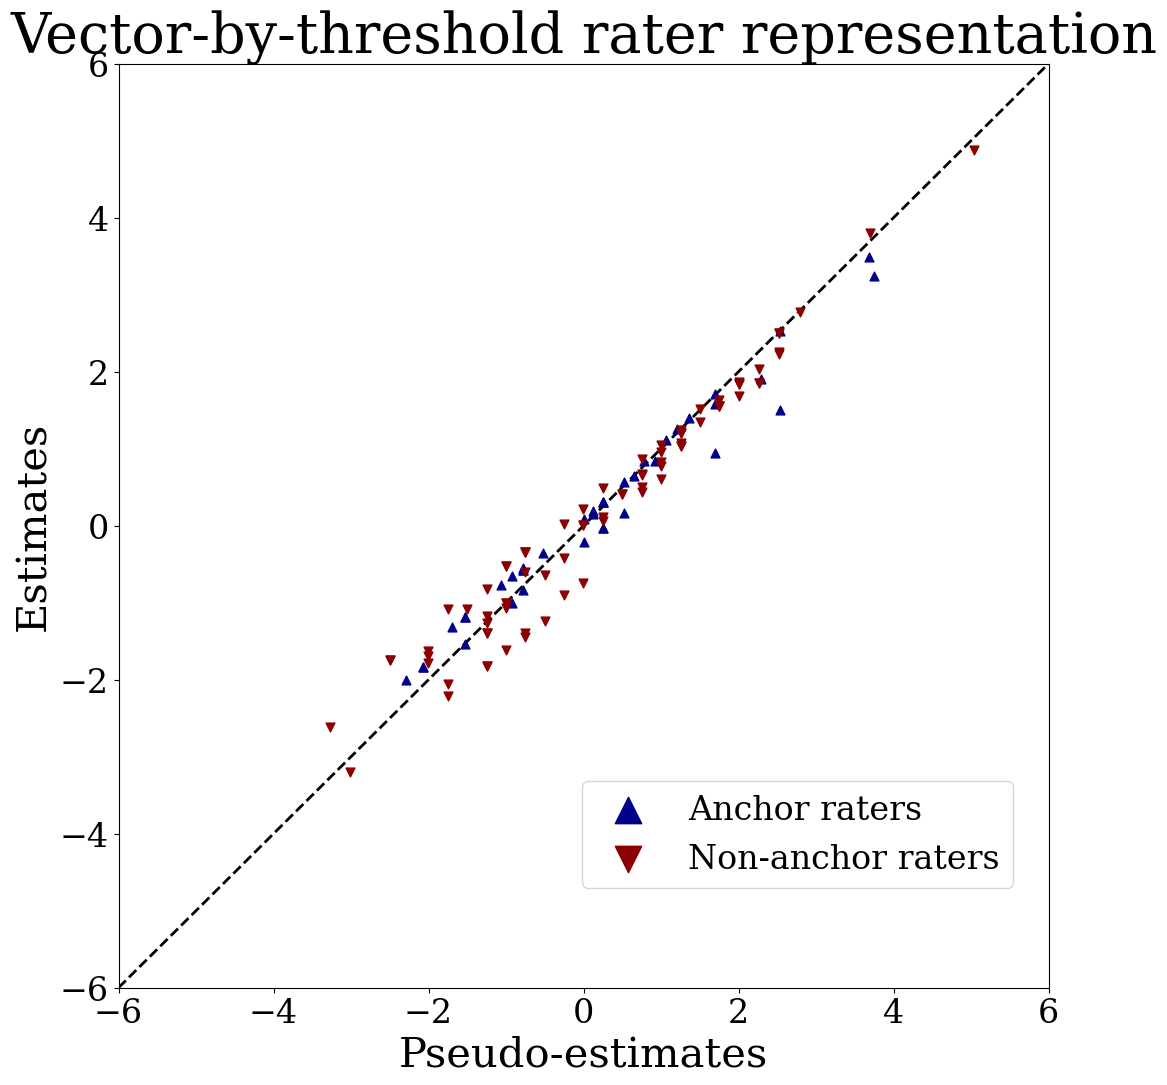

In [81]:
fig, ax = plt.subplots(figsize=(12, 12))

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

plt.plot([-6, 6], [-6, 6], color='k', linestyle='--', linewidth=2, zorder=0)
ax.scatter(pseudo_estimates[:batch_size * no_of_anchors],
           estimates_thresholds[:batch_size * no_of_anchors],
           label="Anchor raters",
           marker='^',
           color='darkblue', s=40)
ax.scatter(pseudo_estimates[batch_size * no_of_anchors:],
           estimates_thresholds[batch_size * no_of_anchors:],
           label="Non-anchor raters",
           marker='v',
           color='darkred', s=40)

plt.xlim(-6, 6)
plt.ylim(-6, 6)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.title('Vector-by-threshold rater representation', {'fontsize': 40})
plt.xlabel('Pseudo-estimates', {'fontsize': 30})
plt.ylabel('Estimates', {'fontsize': 30})

ax.legend(loc='lower right', fontsize=24, markerscale=3, bbox_to_anchor=(0.98, 0.09))

plt.savefig(f'scatter_abils_residual_matrix_{batch_size}.png',
            dpi = 200,
            bbox_inches = 'tight',
            pad_inches = 0.1)

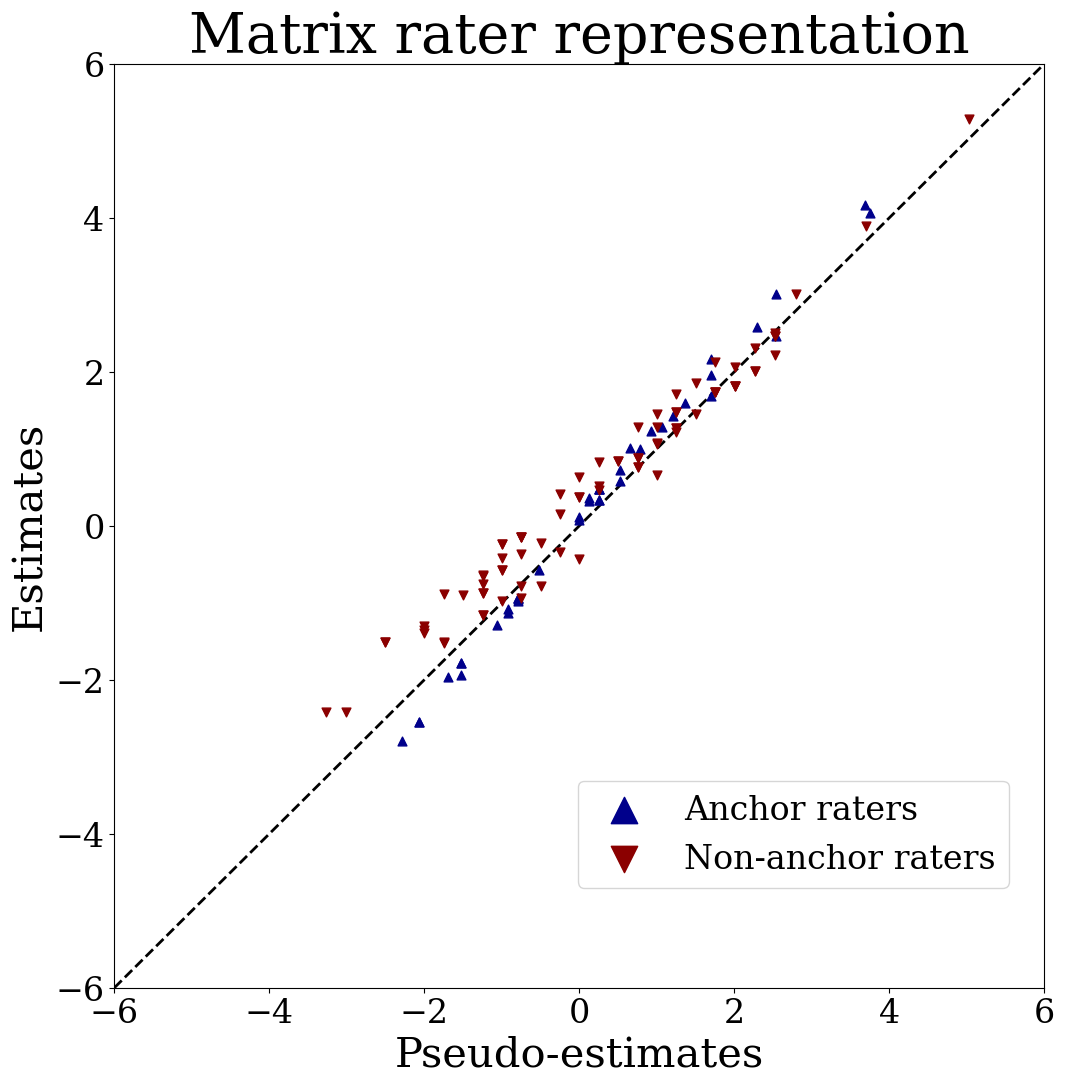

In [82]:
fig, ax = plt.subplots(figsize=(12, 12))

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

plt.plot([-6, 6], [-6, 6], color='k', linestyle='--', linewidth=2, zorder=0)
ax.scatter(pseudo_estimates[:batch_size * no_of_anchors],
           estimates_matrix[:batch_size * no_of_anchors],
           label="Anchor raters",
           marker='^',
           color='darkblue', s=40)
ax.scatter(pseudo_estimates[batch_size * no_of_anchors:],
           estimates_matrix[batch_size * no_of_anchors:],
           label="Non-anchor raters",
           marker='v',
           color='darkred', s=40)

plt.xlim(-6, 6)
plt.ylim(-6, 6)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.title('Matrix rater representation', {'fontsize': 40})
plt.xlabel('Pseudo-estimates', {'fontsize': 30})
plt.ylabel('Estimates', {'fontsize': 30})

ax.legend(loc='lower right', fontsize=24, markerscale=3, bbox_to_anchor=(0.98, 0.09))

plt.savefig(f'scatter_abils_residual_matrix_{batch_size}.png',
            dpi = 200,
            bbox_inches = 'tight',
            pad_inches = 0.1)

**Statistical output**

Define functions for RMSE, SD ratio and RMS parameter estimation residual metrics

In [83]:
def rmse(x, y):

    mse = ((x - y) ** 2).mean()
    
    return np.sqrt(mse)

def sd_ratio(x, y):

    return y.std() / x.std()

Calculate RMSEs for parameter estimates

In [84]:
rmse_items_global = rmse(mfrm.anchor_diffs_global, sim.diffs)
rmse_items_items = rmse(mfrm.anchor_diffs_items, sim.diffs)
rmse_items_thresholds = rmse(mfrm.anchor_diffs_thresholds, sim.diffs)
rmse_items_matrix = rmse(mfrm.anchor_diffs_matrix, sim.diffs)

In [85]:
rmse_thresholds_global = rmse(mfrm.anchor_thresholds_global, sim.thresholds)
rmse_thresholds_items = rmse(mfrm.anchor_thresholds_items, sim.thresholds)
rmse_thresholds_thresholds = rmse(mfrm.anchor_thresholds_thresholds, sim.thresholds)
rmse_thresholds_matrix = rmse(mfrm.anchor_thresholds_matrix, sim.thresholds)

In [86]:
sevs_dict = {rater: pd.DataFrame(sim.severities[rater]).iloc[1:] for rater in sim.raters}
sevs_df = pd.concat(sevs_dict.values(), keys=sevs_dict.keys())

sevs_dict_items = {rater: sevs_dict[rater].iloc[1:].mean()
                   for rater in sim.raters}
sevs_df_items = pd.DataFrame(sevs_dict_items)
sevs_series_items = sevs_df_items.unstack()
rmse_severities_items = rmse(pd.DataFrame(mfrm.anchor_severities_items).unstack(), sevs_series_items)

sevs_dict_thresholds = {rater: sevs_dict[rater].T.iloc[:, 1:].mean()
                   for rater in sim.raters}
sevs_series_thresholds = pd.DataFrame(sevs_dict_thresholds).unstack()
rmse_severities_thresholds = rmse(pd.DataFrame(mfrm.anchor_severities_thresholds).iloc[1:].unstack(), sevs_series_thresholds)

sevs_dict_matrix = {rater: pd.DataFrame(mfrm.anchor_severities_matrix[rater]).iloc[1:] for rater in sim.raters}
sevs_df_matrix = pd.concat(sevs_dict_matrix.values(), keys=sevs_dict_matrix.keys())
sevs_series_matrix = sevs_df_matrix.unstack().unstack()
rmse_severities_matrix = rmse(sevs_df.unstack().unstack(), sevs_series_matrix)

In [87]:
rmse_abilities_global = rmse(estimates_global, base_abils)
rmse_abilities_items = rmse(estimates_items, base_abils)
rmse_abilities_thresholds = rmse(estimates_thresholds, base_abils)
rmse_abilities_matrix = rmse(estimates_matrix, base_abils)

In [88]:
rms_ability_residuals_global = rmse(estimates_global, pseudo_estimates)
rms_ability_residuals_items = rmse(estimates_items, pseudo_estimates)
rms_ability_residuals_thresholds = rmse(estimates_thresholds, pseudo_estimates)
rms_ability_residuals_matrix = rmse(estimates_matrix, pseudo_estimates)

Calculate parameter-estimation residuals

In [89]:
scores_df = mfrm.dataframe.loc[(slice(None), base_abils.index), :]

residuals_generating = scores_df - exp_score_df_generating
residuals_global = scores_df - exp_score_df_global
residuals_items = scores_df - exp_score_df_items
residuals_thresholds = scores_df - exp_score_df_thresholds
residuals_matrix = scores_df - exp_score_df_matrix

In [90]:
param_est_residuals_global = residuals_global - residuals_generating
param_est_residuals_items = residuals_items - residuals_generating
param_est_residuals_thresholds = residuals_thresholds - residuals_generating
param_est_residuals_matrix = residuals_matrix - residuals_generating

In [91]:
param_est_residuals_global = param_est_residuals_global.unstack().unstack().dropna()
param_est_residuals_items = param_est_residuals_items.unstack().unstack().dropna()
param_est_residuals_thresholds = param_est_residuals_thresholds.unstack().unstack().dropna()
param_est_residuals_matrix = param_est_residuals_matrix.unstack().unstack().dropna()

Calculate RMS of parameter-estimation residuals

In [92]:
rms_param_est_residuals_global = np.sqrt((param_est_residuals_global ** 2).mean())
rms_param_est_residuals_items = np.sqrt((param_est_residuals_items ** 2).mean())
rms_param_est_residuals_thresholds = np.sqrt((param_est_residuals_thresholds ** 2).mean())
rms_param_est_residuals_matrix = np.sqrt((param_est_residuals_matrix ** 2).mean())

Generate results table and save to file.

In [93]:
results_df = pd.DataFrame()
results_df['Global'] = {'RMSE items': rmse_items_global,
                        'RMSE thresholds': rmse_thresholds_global,
                        'RMSE severities': '',
                        'RMSE abilities': rmse_abilities_global,
                        'RMS ability residuals': rms_ability_residuals_global,
                        'RMS Parameter estimation residual': rms_param_est_residuals_global}
results_df['Items'] = {'RMSE items': rmse_items_items,
                       'RMSE thresholds': rmse_thresholds_items,
                       'RMSE severities': rmse_severities_items,
                       'RMSE abilities': rmse_abilities_items,
                       'RMS ability residuals': rms_ability_residuals_items,
                       'RMS Parameter estimation residual': rms_param_est_residuals_items}
results_df['Thresholds'] = {'RMSE items': rmse_items_thresholds,
                            'RMSE thresholds': rmse_thresholds_thresholds,
                            'RMSE severities': rmse_severities_thresholds,
                            'RMSE abilities': rmse_abilities_thresholds,
                            'RMS ability residuals': rms_ability_residuals_thresholds,
                            'RMS Parameter estimation residual': rms_param_est_residuals_thresholds}
results_df['Matrix'] = {'RMSE items': rmse_items_matrix,
                        'RMSE thresholds': rmse_thresholds_matrix,
                        'RMSE severities': rmse_severities_matrix,
                        'RMSE abilities': rmse_abilities_matrix,
                        'RMS ability residuals': rms_ability_residuals_matrix,
                        'RMS Parameter estimation residual': rms_param_est_residuals_matrix}

results_df.to_csv(f'Results_{batch_size}.csv')

View results dataframe

In [94]:
round(results_df, 3)

,Global,Items,Thresholds,Matrix
RMSE items,0.31914,0.225,0.319,0.162
RMSE thresholds,0.634687,0.635,0.354,0.283
RMSE severities,,0.525,0.523,1.331
RMSE abilities,0.64663,0.655,0.516,0.570
RMS ability residuals,0.499683,0.506,0.324,0.377
RMS Parameter estimation residual,0.360311,0.417,0.250,0.397
